# Pseudo-random number generators
As we've seen, generating random numbers can be labor intensive if we want to do analyses that rely on having a lot of them!  Flipping coins is obviously limited by physical processes, and even using tools like random.org are (explicitly) rate limited.  Because of this, we would like to be able to generate random numbers on our own computers.  You began to explore this process in your computing assignment - here we will review the random number generators described there, introduce a few more, and also discuss a handful of methods used to evaluate their quality and "randomness" (some of which we've already seen).

## Early attempts
Early use of random numbers tended to rely upon published tables (like published in a long book) of digits drawn from a variety of random sources.  However, with the advent and increased use randomized algorithms, Monte Carlo methods, and other types of computational statistical inference, there was a significant need for scientists to be able to generate numbers that could capture the most salient aspects of randomness within the context of their own computers, and to do so fast.  Of course it is impossible for a deterministic computer to produce randomness - this is inconsistent with a deterministic model of computation - yet early researchers were able to find a few methods that proved useful.   
### Middle Squares
Jon von Neumann is typically credited with the first pseudo-random number generator, implemented on the ENIAC and called the middle square method.  While developed somewhat earlier, a paper (or rather conference proceedings) describing it was published in 1951.  It's available on the course moodle and is full of funny quips and provides an interesting window into how early computer scientists thought about some problems that we now don't much think about.  Perhaps the best known quote from this paper is that 'Anyone who considers arithmetical methods of producing random digits is, of course, in a state of sin.'  However, there are some other interesting ones like 'I think nobody who is practically concerned \[with randomness\] will want to use a sequence produced by any' method without testing it statistically, and it has been the uniform experience with those sequences that it is more trouble to test them than to manufacture them. Hence the degree of complication of the method by which you make them is not terribly important; what is important is to carry out a relatively quick and efficient test.

In any case, the method is straightforward: starting with a $n$-digit integer as a seed, square it so as to produce a $2n$ digit integer (possibly zero-padding the input to produce the right number of digits), and then take the middle $n$ digits from the result to get the next seed and so on.  This method produces integers that are in principle uniformly distributed between $0$ and $10^n$ (although it should be immediately clear that the method will never actually produce a zero).  This is remarkably straightforward to implement.  

In [181]:
import matplotlib.pyplot as plt
import numpy as np
seed = 12345678

class MiddleSquare:
    def __init__(self,seed,num_digits):
        
        self.seed = seed
        self.num_digits = num_digits
        self.format_string = '0'+str(2*num_digits)

    def generate(self):
        x_square = self.seed**2
        x_string = f"{x_square:{self.format_string}}"
        x_string = x_string[self.num_digits//2:self.num_digits + self.num_digits//2]
        self.seed = int(x_string)
        return self.seed

    def generate_sequence(self,seq_length,normalize=True):
        sequence = []
        for _ in range(seq_length):
            sequence.append(self.generate())

        sequence = np.array(sequence)

        if normalize:
            sequence = sequence/10**self.num_digits

        return sequence
    
generator = MiddleSquare(seed,8)
sequence = generator.generate_sequence(100000,normalize=False)
print(sequence)

[41576527 60759738 74576182 ... 36960000  4160000 30560000]


Great.  Now it's worthwhile to start doing some analysis of the random properties.  The most obvious thing to do is to plot a histogram. 

(array([1.00646735e-08, 9.98065116e-09, 9.97865063e-09, 1.00006565e-08,
        9.99765568e-09, 9.98465222e-09, 1.00056578e-08, 9.98565249e-09,
        1.00316647e-08, 9.99665541e-09]),
 array([1.53900000e+04, 1.00127337e+07, 2.00100774e+07, 3.00074211e+07,
        4.00047648e+07, 5.00021085e+07, 5.99994522e+07, 6.99967959e+07,
        7.99941396e+07, 8.99914833e+07, 9.99888270e+07]),
 <BarContainer object of 10 artists>)

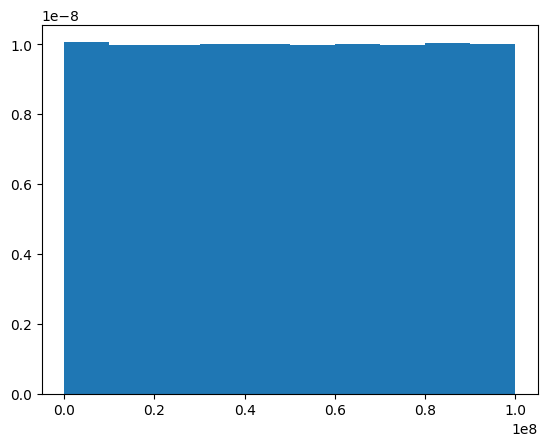

In [149]:
plt.figure()
plt.hist(sequence,10,density=True)

This looks pretty reasonable for 10 bins, but let's see what it looks like with higher granularity (we have a lot of samples after all).

(array([1.90850696e-08, 1.09028961e-09, 9.91263309e-09, 9.96264638e-09,
        1.91650908e-08, 1.13030024e-09, 1.01426942e-08, 9.96264638e-09,
        1.90750669e-08, 1.12029758e-09, 9.79260121e-09, 9.89262778e-09,
        1.89550350e-08, 1.06028164e-09, 1.00426676e-08, 9.81260652e-09,
        1.91250802e-08, 1.13030024e-09, 1.00926809e-08, 9.90263044e-09,
        1.89250271e-08, 1.05027899e-09, 9.81260652e-09, 9.91263309e-09,
        1.89550350e-08, 1.16030821e-09, 9.96264638e-09, 9.99265435e-09,
        1.89450324e-08, 1.07028430e-09, 9.76259324e-09, 1.00526703e-08,
        1.89350297e-08, 1.33035338e-09, 9.98265169e-09, 1.01326915e-08,
        1.88149978e-08, 1.08028696e-09, 9.82260918e-09, 1.00926809e-08,
        1.89050217e-08, 1.00026570e-09, 9.97264903e-09, 1.00526703e-08,
        1.92051015e-08, 9.10241788e-10, 9.79260121e-09, 1.01626995e-08,
        1.89750403e-08, 1.00026570e-09, 1.00026570e-08, 1.00026570e-08,
        1.88550085e-08, 1.09028961e-09, 9.91263309e-09, 1.006267

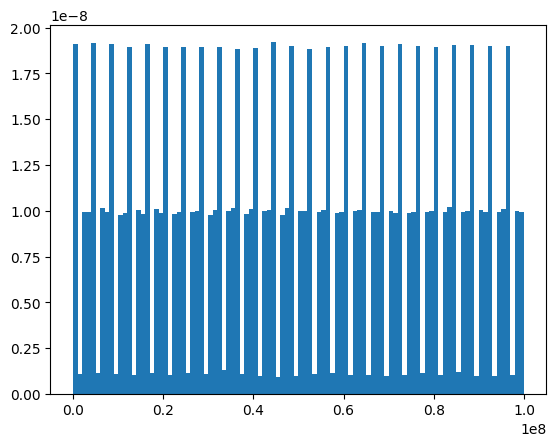

In [153]:
plt.figure()
plt.hist(sequence,100,density=True)

Clearly, we're seeing structure that is inconsistent with sampling error.  Indeed, this structure implies a particularly pathological sort of periodicity where the sequence is stuck in a loop but is not reaching all the possible integers before repeating.  We can easily see that this is the case by plotting the last few hundred samples of the sequence

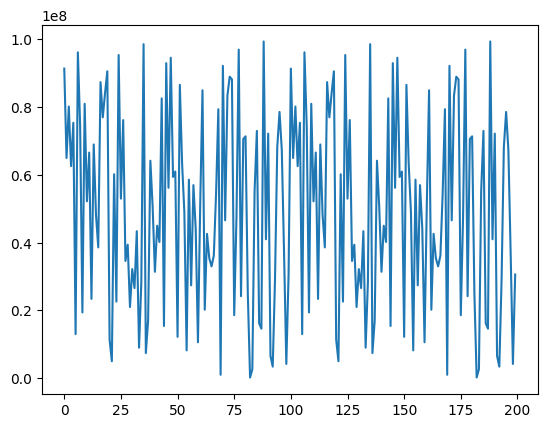

In [154]:
plt.figure()
plt.plot(sequence[-200:])

It's interesting to see how long it takes before we start seeing repeats.  Below, I've extracted the counts for each entry in the sequence, selected the lowest repeating value, and plotted the indicator variable of where it occurs.  Clearly after around 10000 generated digits, we fall into the bad pattern.

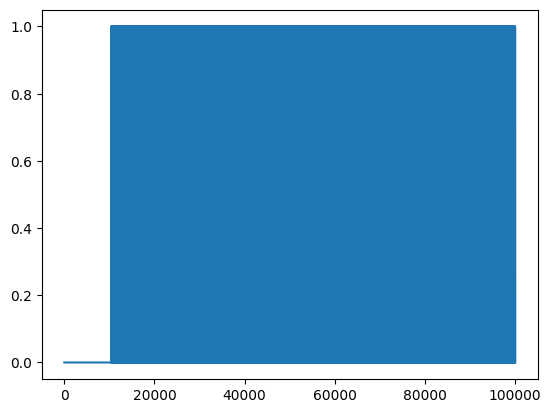

In [155]:
vals,counts = np.unique(sequence,return_counts=True)
repeat_vals = vals[counts!=1]
plt.figure()
plt.plot(sequence==repeat_vals[0])

(0.0, 12000.0)

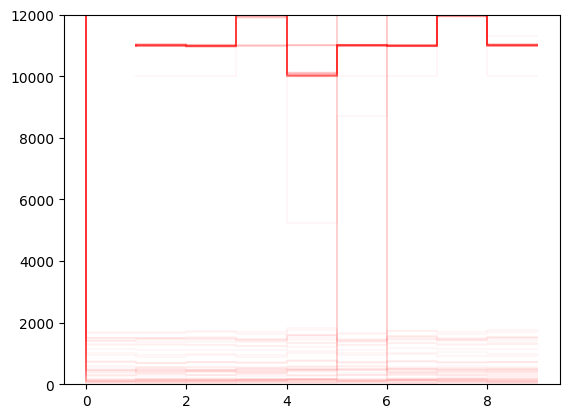

In [173]:

for t in range(100):   
    generator = MiddleSquare(12345678+t,8)
    sequence = generator.generate_sequence(100000,normalize=False)
    first_digits = [int(str(s)[0]) for s in sequence]
    digit,count = np.unique(first_digits,return_counts=True)
    plt.step(digit,count,color='r',alpha=.03)
plt.ylim(0,12000)


(0.0, 12000.0)

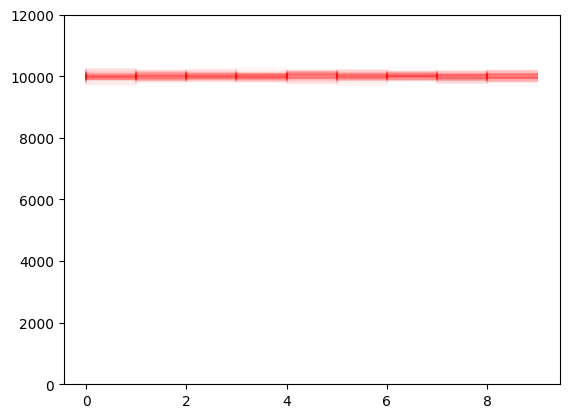

In [170]:
for t in range(100):
    samples = np.random.randint(0,10,100000)
    digit,count = np.unique(samples,return_counts=True)
    plt.step(digit,count,color='r',alpha=0.03)

plt.ylim(0,12000)

Let's see how this method fares under the classic test of single bit frequencies.  

In [182]:
sequence = sequence[:6000]

In [183]:
def IntToBits(sequence,n_bits):
    return "".join([bin(s)[2:][-n_bits:].zfill(n_bits) for s in sequence])
    
ms_bitstring = IntToBits(sequence,24)
ms_bitstring.count("1")/len(ms_bitstring)

0.49683333333333335

Although it's obviously the case that this is going to go wrong, it's interesting to check how this method does for run lengths.  

In [184]:
import numpy as np
def count_runs(sequence,max_run_length=20):
    num_runs = np.zeros(max_run_length)
    run_length = 0
    for j,bit in enumerate(sequence):
        if bit == '1':
            run_length += 1
        else:
            num_runs[run_length] += 1
            run_length = 0
    return num_runs

def theoretical_runs(sequence_length,max_run_length=20):
    i = np.linspace(0,max_run_length-1,max_run_length)
    return (sequence_length - i + 3)*0.5**(i+2)
            

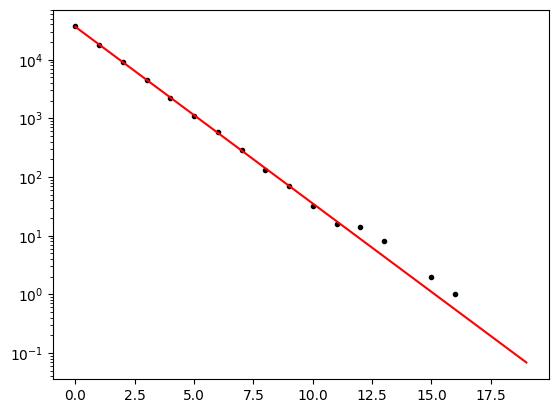

In [185]:
plt.figure()
measured = count_runs(ms_bitstring)
predicted = theoretical_runs(len(ms_bitstring))


plt.semilogy(measured,'k.')
plt.semilogy(predicted,'r-')

This is a pretty significant deviation.  It's more egregious when we recognize that this method favors zeros - so we can look at the distribution of runs of zeros instead

In [177]:
ms_bitstring_inv = ''.join('1' if x=='0' else '0' for x in ms_bitstring)

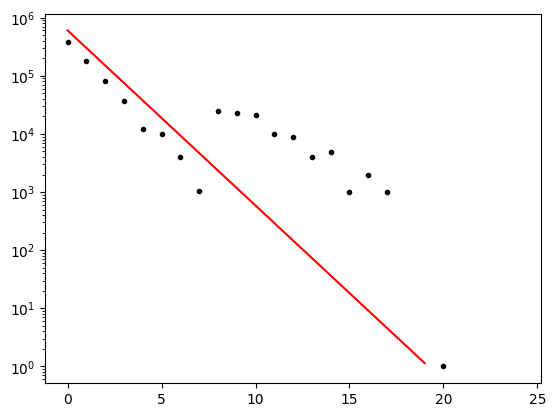

In [179]:
plt.figure()
measured = count_runs(ms_bitstring_inv,max_run_length=25)
predicted = theoretical_runs(len(ms_bitstring_inv))


plt.semilogy(measured,'k.')
plt.semilogy(predicted,'r-')

In [180]:
sequence

array([41820973, 99378266,  3975316, ..., 34560000, 39360000, 20960000])

### Logistic Map (Ulam)
Amusingly, in von Neumann's paper he writes "A simpler process suggested by Dr. Ulam is to use the mapping function $x_{i+1}=r x_i(1-x_i)$. If one produces a sequence $x_i$ in this manner, $x_{i+1}$ is completely determined by $x_i$, so that independence is lacking. It is, however,
quite instructive to analyze the nature of randomness that exists in this sequence."  The Dr. Ulam who von Neumann references is Stansilaw Ulam of atomic bomb fame (among other things), and the function that he suggests is the so-called logistic map.  The logistic map is the classic and perhaps simplest example of mathematical chaos, and it has been much studied - you may have seen this diagram:

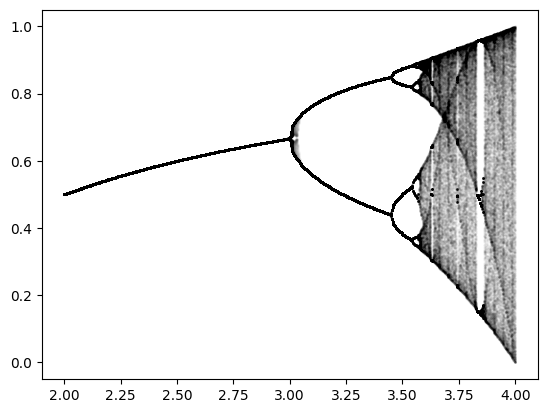

In [186]:
plt.figure()
x0 = 0.33
niters = 1000
rs = np.linspace(2,4,501)
for r in rs:
    xs = [x0]
    for i in range(niters):
        xs.append(r*xs[-1]*(1-xs[-1]))
    plt.scatter(np.ones_like(xs[100:])*r,xs[100:],c='k',s=1.0,alpha=0.02)
    

While there is significant structure, it is typically understood that for the parameter $r=4$, this function is fully chaotic.  Indeed, it is quite reasonable to interpret the values produced by this function to be random real numbers on the closed interval (0,1).  Note that we haven't studied distributions over the uncountable reals yet - but we'll make do with intuition.  First, let's generate a longer sequence 

In [2]:
class Logistic:
    def __init__(self,seed):
        self.seed = seed
        
    def generate(self):
        self.seed = 4*self.seed*(1-self.seed)
        return self.seed

    def generate_sequence(self,seq_length):
        sequence = []
        for _ in range(seq_length):
            sequence.append(self.generate())

        sequence = np.array(sequence)

        return sequence

generator = Logistic(.12345)
sequence = generator.generate_sequence(100000)

As before, a first check is to look at the histogram.

(array([3.29300001, 1.3635    , 1.04975   , 0.92725   , 0.81675   ,
        0.75325   , 0.72975   , 0.698     , 0.679     , 0.6365    ,
        0.641     , 0.64575   , 0.6525    , 0.629     , 0.637     ,
        0.64225   , 0.67325   , 0.6825    , 0.7285    , 0.77775   ,
        0.81675   , 0.9375    , 1.0555    , 1.32875   , 3.20525001]),
 array([2.51436161e-09, 4.00000024e-02, 8.00000023e-02, 1.20000002e-01,
        1.60000002e-01, 2.00000002e-01, 2.40000002e-01, 2.80000002e-01,
        3.20000002e-01, 3.60000001e-01, 4.00000001e-01, 4.40000001e-01,
        4.80000001e-01, 5.20000001e-01, 5.60000001e-01, 6.00000001e-01,
        6.40000001e-01, 6.80000000e-01, 7.20000000e-01, 7.60000000e-01,
        8.00000000e-01, 8.40000000e-01, 8.80000000e-01, 9.20000000e-01,
        9.59999999e-01, 9.99999999e-01]),
 <BarContainer object of 25 artists>)

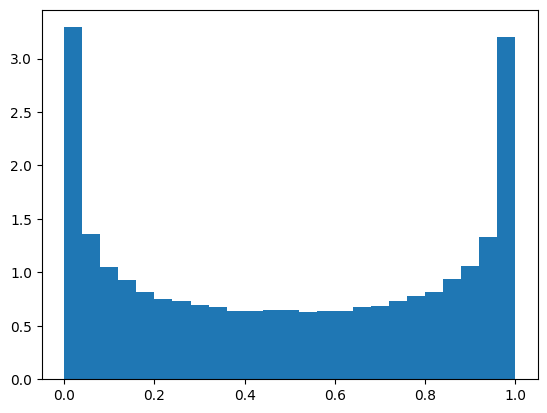

In [188]:
plt.figure()
plt.hist(sequence,25,density=True,cumulative=False)

Regrettably, something is already wrong - this distribution is clearly not uniform over the stated interval.  However, perhaps there is a way to transform these samples such that they are uniform.  Indeed, it is frequently done such that if we have a uniform distribution, we transform into something else via so-called "inverse transform sampling" which works by applying the inverse of the cumulative mass (or density) function to the uniform variable.  Here, we are trying to go the other way, (inverse inverse transform sampling), and so we can apply the CDF of the logistic map to get samples from the uniform distribution.  Clever folks have determined that the values produced by the logistic map are distributed according to 
$$
P(x) = \frac{1}{\pi} (x (1-x))^{-\frac{1}{2}}
$$


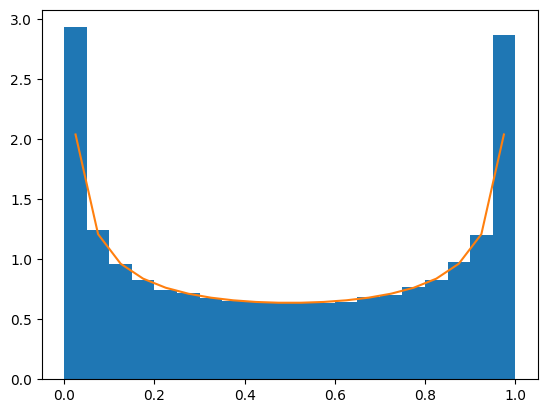

In [189]:
plt.figure()
_,x_bins,_ = plt.hist(sequence,20,density=True,cumulative=False)
x_bins = (x_bins[1:] + x_bins[:-1])/2.
plt.plot(x_bins,1/np.pi*(x_bins*(1-x_bins))**-0.5)

If we integrate this from zero to $x$, we get the function
$$
\frac{1}{\pi}\cos^{-1}(1 - 2x).
$$
Application to the samples gives us

(array([1.11805354, 1.08105176, 1.02504908, 1.0170487 , 1.03404951,
        1.01204846, 0.99504765, 1.00404808, 1.0420499 , 0.99004741,
        0.99304755, 1.0190488 , 1.01604865, 0.95004549, 1.04304994,
        1.01004836, 1.01104841, 1.01004836, 1.01104841, 1.01804875,
        0.99504765, 0.94904544, 0.96504621, 0.98504717, 1.04505004,
        0.9940476 , 0.97004645, 0.96004597, 1.02504908, 0.96804635,
        1.02804923, 0.96404616, 0.97304659, 1.00604817, 1.00704822,
        1.00104793, 1.00404808, 1.02604913, 1.01004836, 0.97804683,
        1.02604913, 0.9690464 , 0.97504669, 1.00104793, 0.9230442 ,
        1.03004932, 1.02704918, 1.00304803, 1.01604865, 1.01204846,
        1.02704918, 0.99304755, 0.9920475 , 0.99104745, 0.98604722,
        0.96204607, 1.00904832, 0.95404568, 0.99604769, 0.96104602,
        1.04905023, 1.02104889, 0.98504717, 0.99304755, 0.93104458,
        1.04805018, 0.95604578, 1.00604817, 1.01304851, 1.04304994,
        0.98704726, 0.94104506, 0.98704726, 1.01

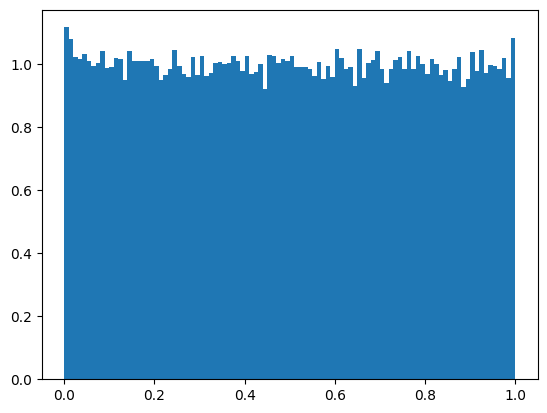

In [192]:
plt.figure()
sequence_transformed = 1./np.pi*np.arccos(1 - 2*sequence)
plt.hist(sequence_transformed,100,density=True)

which looks pretty uniform.  For monobit testing, we can get 32 bit integers by multiplying by $2^{32}$ and taking the floot.

In [193]:
sequence_int = (sequence_transformed*(2**32)).astype(np.int32)

/tmp/ipykernel_250079/257338386.py:1: RuntimeWarning: invalid value encountered in cast
  sequence_int = (sequence_transformed*(2**32)).astype(np.int32)


In [194]:
sequence_int = (sequence_transformed*(2**32)).astype(int)
bitstring_logistic = IntToBits(sequence_int,32)

In [195]:
bitstring_logistic.count("1")/len(bitstring_logistic)

0.5000396875

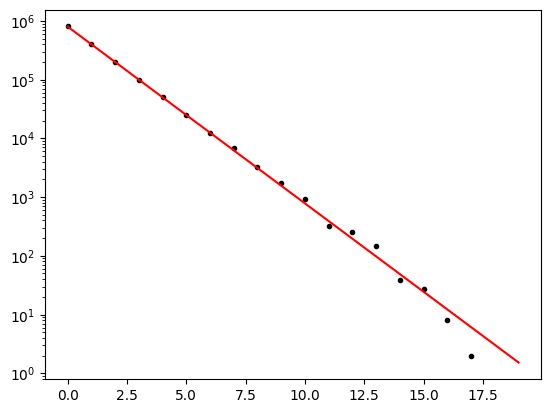

In [196]:
plt.figure()
measured = count_runs(bitstring_logistic)
predicted = theoretical_runs(len(bitstring_logistic))


plt.semilogy(measured,'k.')
plt.semilogy(predicted,'r-')

This appears to work very well!  However, there are some peculiarities.  Let's reshape our sequence into 2D points and plot these to see if there exists some structure.      






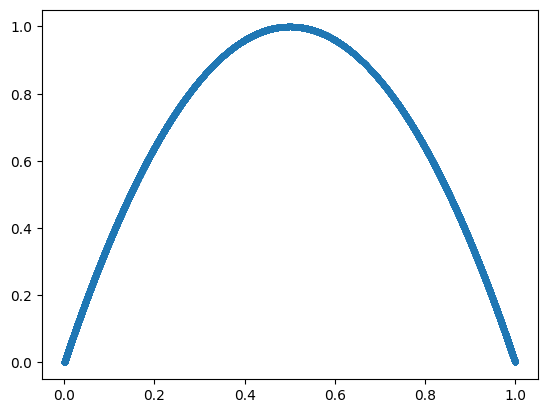

In [197]:
plt.figure()
plt.plot(*sequence.reshape(-1,2).T,'.')

Clearly, the next value is easily predicted from the last (which isn't surprising).  However, we can examine this (or the equations themselves) to immediately see that this system has some badly behaved fixed points (not unlike the middle-square method).  For example, if we start at 0.5, we get 1, from 1 we get zero, and from zero, we stay at zero.  Because we are working with floating point arithmetic (rather than exact), there is a real probability that we will eventually end up at something which rounds to 0.5, and from there we devolve to the uniform 0 sequence.  Perhaps more perniciously, the logistic map has an infinite number of repeating sequences.  These can be found from solving recurrence relations, but one example is the seed $x=\sin^2 (\pi/7)$, which produces a 3-cycle.

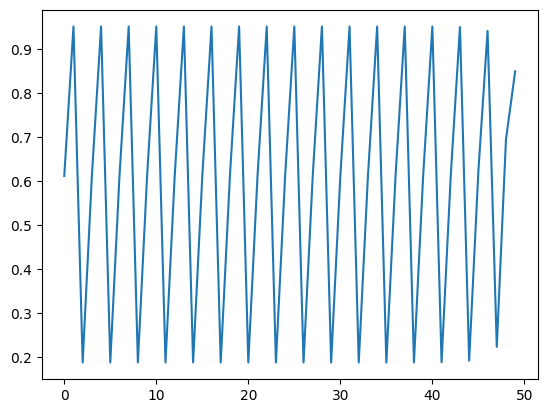

In [50]:
plt.figure()
generator = Logistic(np.sin(np.pi*6/7)**2)
sequence_bad = generator.generate_sequence(50)
plt.plot(sequence_bad)

Accidentally falling into such cycles as a result of round-off error is difficult to analyze, unpredictable, and challenging to recognize.  It is clear that it gets worse by using lower-precision numbers and with longer sequences.  Indeed, von Neumann writes of this method: 'However, any physically existing machine has a certain limit of precision. Since the average value of |f'(x)| on (0,1) is 2, in each transformation from $x_i$ to $x_i+1$ any error will be amplified on the average by approximately two. In about 33 steps the first round-off error will have grown to about $10^{10}$. No matter how random the sequence $x_d$ is in theory, after about 33 steps one is really only testing the random properties of the round-off error. Then one might as well admit that one can prove nothing, because the amount of theoretical information about the statistical properties of the round-off mechanism is nil.'

## CAT testing
Nonetheless, because the logistic map does well with respect to the tests that we have, it is perhaps worthwhile to develop some more complex tests besides simply runs and frequencies that we can use to evaluate our PRNGs.  One class of such tests are the so-called monkey tests.  These are named as such based on the infinite monkey theorem, which states that given a monkey randomly hitting keys on a keyboard, eventually that monkey will type the collected work of Shakespeare (or any other sequence) given infinite time.  Of course that may take a long time - it is also reasonable to ask about somewhat less improbable tests.  For example, how long does it take for the monkey to type the word CAT?  I claim that you can figure this out for yourself fairly straightforwardly.  Take a few minutes and see if you, along with your classmates, can derive the distribution (and precise probability) for how many letters (from an alphabet of 26) can be typed before seeing the word CAT (or any other particular three letter sequence).   

In [75]:
import numpy as np
import string
import matplotlib.pyplot as plt

alphabet = string.ascii_letters[:26]
n_alphabet = len(alphabet)

def trial(query,generator,maxiter=1e6,print_status=False,log=False):
    found = False
    string_buffer = 'aaa'
    counter = 0
    log_list = []
    while found==False and counter<maxiter:
        try:
            counter += 1
            if string_buffer == query:
                break
            random_number = generator.generate()
            random_letter = alphabet[int(random_number*26)]
            string_buffer = string_buffer[1:] + random_letter
            if log:
                log_list.append(string_buffer)
        except IndexError:
            print(random_number)
        if counter%1000==0 and print_status:
            print(counter,string_buffer)
    if log:
        return counter,log_list
    else:
        return counter

import time
generator = Logistic(time.time()%1)
counter, log = trial('cat',generator,print_status=False, log=True)
print(counter)

1000000


Frustratingly, we never see cat at all!  Perhaps it's informative to see how many distinct words we actually *do* see and compare that to how many we expect to see.  

In [61]:
import time
generator = Logistic(time.time()%1)
counter,log_list = trial('cat',generator,print_status=False,log=True)

In [62]:
np.unique(log_list)

array(['aaa', 'aab', 'aac', 'aad', 'aay', 'abd', 'abe', 'abf', 'abg',
       'abh', 'ach', 'aci', 'acj', 'ack', 'adk', 'adl', 'adm', 'adn',
       'ayf', 'bdn', 'ben', 'beo', 'bep', 'beq', 'bfq', 'bfr', 'bfs',
       'bgs', 'bgt', 'bgu', 'bhu', 'bhv', 'chv', 'chw', 'ciw', 'cix',
       'cjx', 'cjy', 'cky', 'ckz', 'dkz', 'dlz', 'dmz', 'dnz', 'enz',
       'eoz', 'epy', 'epz', 'eqy', 'fqx', 'fqy', 'frw', 'frx', 'fsv',
       'fsw', 'gsu', 'gsv', 'gts', 'gtt', 'gtu', 'gur', 'gus', 'huq',
       'hur', 'hvn', 'hvo', 'hvp', 'hvq', 'hwn', 'iwk', 'iwl', 'iwm',
       'iwn', 'ixi', 'ixj', 'ixk', 'jxh', 'jxi', 'jyf', 'jyg', 'jyh',
       'kyd', 'kye', 'kyf', 'kzc', 'kzd', 'lza', 'lzb', 'lzc', 'mza',
       'nza', 'oza', 'ozb', 'ozc', 'pyd', 'pye', 'pyf', 'pzc', 'pzd',
       'qxh', 'qxi', 'qyf', 'qyg', 'qyh', 'rwk', 'rwl', 'rwm', 'rwn',
       'rxi', 'rxj', 'rxk', 'suq', 'sur', 'svn', 'svo', 'svp', 'svq',
       'swn', 'tsu', 'tsv', 'tts', 'ttt', 'ttu', 'tur', 'tus', 'uqx',
       'uqy', 'urw',

(array([629., 230.,  88.,  31.,  19.,   1.,   0.,   1.,   0.,   1.]),
 array([1.600000e+01, 1.713540e+04, 3.425480e+04, 5.137420e+04,
        6.849360e+04, 8.561300e+04, 1.027324e+05, 1.198518e+05,
        1.369712e+05, 1.540906e+05, 1.712100e+05]),
 <BarContainer object of 10 artists>)

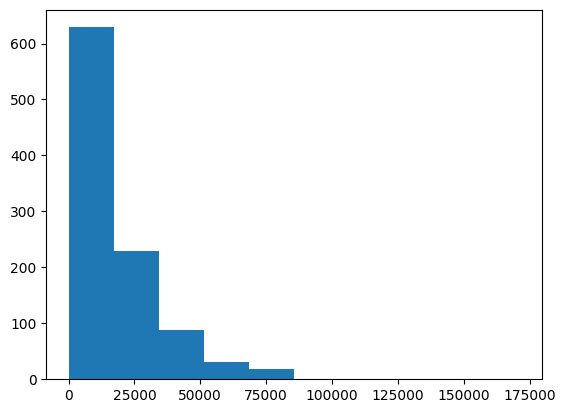

In [76]:
class BuiltinGenerator:
    def __init__(self):
        pass
    def generate(self):
        return np.random.rand()


trials = []
n_trials = 1000
for i in range(n_trials):
    trials.append(trial('cat',BuiltinGenerator()))

plt.hist(trials)

In [77]:
np.mean(trials)

17269.2

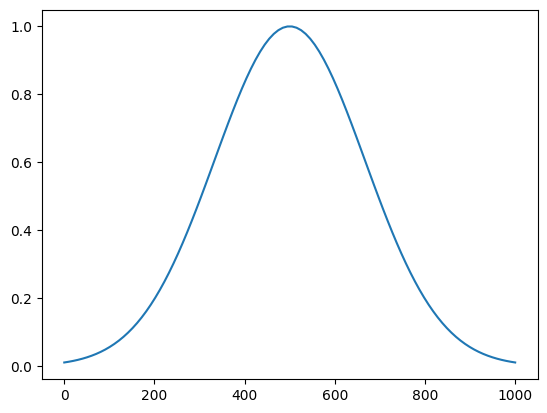

In [78]:
# plot a normal distribution over trials
x = np.linspace(0,n_trials,100)
y = np.exp(-(x-n_trials/2)**2/(2*(n_trials/6)**2))

plt.plot(x,y)